# Sea Ice Diagnostics for two CESM3 runs

In [1]:
import os

import xarray as xr
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
serial = False  # use dask LocalCluster

#case_name = "b.e30_beta02.BLT1850.ne30_t232.104"
#base_case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"

#start_date = "0001-01-01"
#end_date = "0101-01-01"
#base_start_date = "0001-01-01"
#base_end_date = "0101-01-01"

case_name = "b.e30_beta02.BLTHIST.ne30_t232.104"
base_case_name = "b.e30_beta04.BLTHIST.ne30_t232_wgx3.121"

start_date = "1850-01-01"
end_date = "2015-01-01"
base_start_date = "1850-01-01"
base_end_date = "2015-01-01"

climo_nyears = 35
grid_file = "/glade/campaign/cesm/community/omwg/grids/tx2_3v2_grid.nc"
path_nsidc = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data/ice/analysis_datasets/hemispheric_data/NSIDC_SeaIce_extent"

model_path = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_model_data/ice/"
path_lens1 = model_path + "cesm_lens1"
path_lens2 = model_path + "cesm_lens2"

lc_kwargs = {}

In [3]:
cupid_run = 1

if cupid_run == 1:

    from dask.distributed import Client, LocalCluster

    # Spin up cluster (if running in parallel)
    client = None
    if not serial:
        cluster = LocalCluster(**lc_kwargs)
        client = Client(cluster)

else:

    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster(
        cores=16,
        processes=16,
        memory="100GB",
        account="P93300065",
        queue="casper",
        walltime="02:00:00",
    )

    client = Client(cluster)

    cluster.scale(1)

    print(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 1
Total threads: 1,Total memory: 12.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45005,Workers: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 1
Started: Just now,Total memory: 12.00 GiB
Comm: tcp://127.0.0.1:38821,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/41001/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:38293,


# Read in data

### New CESM cases to compare

In [4]:
# Read in two cases. The ADF timeseries are needed here.

ds1 = xr.open_mfdataset(
    os.path.join(
        CESM_output_dir, case_name, "ice", "proc", "tseries", f"{case_name}.cice.h.*.nc"
    ),
    data_vars="minimal",
    compat="override",
    coords="minimal",
).sel(time=slice(start_date, end_date))
ds2 = xr.open_mfdataset(
    os.path.join(
        CESM_output_dir,
        base_case_name,
        "ice",
        "proc",
        "tseries",
        f"{base_case_name}.cice.h.*.nc",
    ),
    data_vars="minimal",
    compat="override",
    coords="minimal",
).sel(time=slice(base_start_date, base_end_date))

ds_grid = xr.open_dataset(grid_file)
TLAT = ds_grid["TLAT"]
TLON = ds_grid["TLONG"]
tarea = ds_grid["TAREA"] * 1.0e-4
angle = ds_grid["ANGLE"]

ds1_ann = ds1.resample(time="YS").mean(dim="time")
ds2_ann = ds2.resample(time="YS").mean(dim="time")

with open("cice_masks.yml", "r") as file:
    cice_masks = yaml.safe_load(file)

first_year = int(start_date.split("-")[0])
base_first_year = int(base_start_date.split("-")[0])
end_year = int(end_date.split("-")[0])
base_end_year = int(base_end_date.split("-")[0])

### CESM1 and CESM2 large ensemble data

In [5]:
### Read in the CESM LENS historical data

ds_cesm1_aicetot_nh = xr.open_dataset(path_lens1 + "/LE_aicetot_nh_1920-2100.nc")
ds_cesm1_hitot_nh = xr.open_dataset(path_lens1 + "/LE_hitot_nh_1920-2100.nc")
ds_cesm1_hstot_nh = xr.open_dataset(path_lens1 + "/LE_hstot_nh_1920-2100.nc")

ds_cesm1_aicetot_sh = xr.open_dataset(path_lens1 + "/LE_aicetot_sh_1920-2100.nc")
ds_cesm1_hitot_sh = xr.open_dataset(path_lens1 + "/LE_hitot_sh_1920-2100.nc")
ds_cesm1_hstot_sh = xr.open_dataset(path_lens1 + "/LE_hstot_sh_1920-2100.nc")

cesm1_aicetot_nh_ann = ds_cesm1_aicetot_nh["aice_monthly"].mean(dim="nmonth")
cesm1_hitot_nh_ann = ds_cesm1_hitot_nh["hi_monthly"].mean(dim="nmonth")
cesm1_hstot_nh_ann = ds_cesm1_hstot_nh["hs_monthly"].mean(dim="nmonth")

cesm1_aicetot_sh_ann = ds_cesm1_aicetot_sh["aice_monthly"].mean(dim="nmonth")
cesm1_hitot_sh_ann = ds_cesm1_hitot_sh["hi_monthly"].mean(dim="nmonth")
cesm1_hstot_sh_ann = ds_cesm1_hstot_sh["hs_monthly"].mean(dim="nmonth")

cesm1_years = xr.cftime_range(start="1920", end="2100", freq="YS", calendar="noleap")

cesm1_aicetot_nh_month = ds_cesm1_aicetot_nh["aice_monthly"][:, 60:95, :].mean(
    dim="nyr"
)
cesm1_hitot_nh_month = ds_cesm1_hitot_nh["hi_monthly"][:, 60:95, :].mean(dim="nyr")
cesm1_hstot_nh_month = ds_cesm1_hstot_nh["hs_monthly"][:, 60:95, :].mean(dim="nyr")
cesm1_aicetot_sh_month = ds_cesm1_aicetot_sh["aice_monthly"][:, 60:95, :].mean(
    dim="nyr"
)
cesm1_hitot_sh_month = ds_cesm1_hitot_sh["hi_monthly"][:, 60:95, :].mean(dim="nyr")
cesm1_hstot_sh_month = ds_cesm1_hstot_sh["hs_monthly"][:, 60:95, :].mean(dim="nyr")

ds_cesm2_aicetot_nh = xr.open_dataset(path_lens2 + "/LE2_aicetot_nh_1870-2100.nc")
ds_cesm2_hitot_nh = xr.open_dataset(path_lens2 + "/LE2_hitot_nh_1870-2100.nc")
ds_cesm2_hstot_nh = xr.open_dataset(path_lens2 + "/LE2_hstot_nh_1870-2100.nc")

ds_cesm2_aicetot_sh = xr.open_dataset(path_lens2 + "/LE2_aicetot_sh_1870-2100.nc")
ds_cesm2_hitot_sh = xr.open_dataset(path_lens2 + "/LE2_hitot_sh_1870-2100.nc")
ds_cesm2_hstot_sh = xr.open_dataset(path_lens2 + "/LE2_hstot_sh_1870-2100.nc")

cesm2_aicetot_nh_ann = ds_cesm2_aicetot_nh["aice_monthly"].mean(dim="nmonth")
cesm2_hitot_nh_ann = ds_cesm2_hitot_nh["hi_monthly"].mean(dim="nmonth")
cesm2_hstot_nh_ann = ds_cesm2_hstot_nh["hs_monthly"].mean(dim="nmonth")

cesm2_aicetot_sh_ann = ds_cesm2_aicetot_sh["aice_monthly"].mean(dim="nmonth")
cesm2_hitot_sh_ann = ds_cesm2_hitot_sh["hi_monthly"].mean(dim="nmonth")
cesm2_hstot_sh_ann = ds_cesm2_hstot_sh["hs_monthly"].mean(dim="nmonth")

cesm2_years = xr.cftime_range(start="1870", end="2100", freq="YS", calendar="noleap")

cesm2_aicetot_nh_month = ds_cesm2_aicetot_nh["aice_monthly"][:, 110:145, :].mean(
    dim="nyr"
)
cesm2_hitot_nh_month = ds_cesm2_hitot_nh["hi_monthly"][:, 110:145, :].mean(dim="nyr")
cesm2_hstot_nh_month = ds_cesm2_hstot_nh["hs_monthly"][:, 110:145, :].mean(dim="nyr")
cesm2_aicetot_sh_month = ds_cesm2_aicetot_sh["aice_monthly"][:, 110:145, :].mean(
    dim="nyr"
)
cesm2_hitot_sh_month = ds_cesm2_hitot_sh["hi_monthly"][:, 110:145, :].mean(dim="nyr")
cesm2_hstot_sh_month = ds_cesm2_hstot_sh["hs_monthly"][:, 110:145, :].mean(dim="nyr")

### NSIDC data

In [6]:
### Read in the NH NSIDC data from files

jan_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_01_extent_v3.0.csv"), na_values=["-99.9"]
)
feb_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_02_extent_v3.0.csv"), na_values=["-99.9"]
)
mar_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_03_extent_v3.0.csv"), na_values=["-99.9"]
)
apr_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_04_extent_v3.0.csv"), na_values=["-99.9"]
)
may_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_05_extent_v3.0.csv"), na_values=["-99.9"]
)
jun_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_06_extent_v3.0.csv"), na_values=["-99.9"]
)
jul_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_07_extent_v3.0.csv"), na_values=["-99.9"]
)
aug_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_08_extent_v3.0.csv"), na_values=["-99.9"]
)
sep_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_09_extent_v3.0.csv"), na_values=["-99.9"]
)
oct_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_10_extent_v3.0.csv"), na_values=["-99.9"]
)
nov_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_11_extent_v3.0.csv"), na_values=["-99.9"]
)
dec_nsidc_nh = pd.read_csv(
    os.path.join(path_nsidc, "N_12_extent_v3.0.csv"), na_values=["-99.9"]
)

jan_area_nh = jan_nsidc_nh.iloc[:, 5].values
feb_area_nh = feb_nsidc_nh.iloc[:, 5].values
mar_area_nh = mar_nsidc_nh.iloc[:, 5].values
apr_area_nh = apr_nsidc_nh.iloc[:, 5].values
may_area_nh = may_nsidc_nh.iloc[:, 5].values
jun_area_nh = jun_nsidc_nh.iloc[:, 5].values
jul_area_nh = jul_nsidc_nh.iloc[:, 5].values
aug_area_nh = aug_nsidc_nh.iloc[:, 5].values
sep_area_nh = sep_nsidc_nh.iloc[:, 5].values
oct_area_nh = oct_nsidc_nh.iloc[:, 5].values
nov_area_nh = nov_nsidc_nh.iloc[:, 5].values
dec_area_nh = dec_nsidc_nh.iloc[:, 5].values

jan_ext_nh = jan_nsidc_nh.iloc[:, 4].values
feb_ext_nh = feb_nsidc_nh.iloc[:, 4].values
mar_ext_nh = mar_nsidc_nh.iloc[:, 4].values
apr_ext_nh = apr_nsidc_nh.iloc[:, 4].values
may_ext_nh = may_nsidc_nh.iloc[:, 4].values
jun_ext_nh = jun_nsidc_nh.iloc[:, 4].values
jul_ext_nh = jul_nsidc_nh.iloc[:, 4].values
aug_ext_nh = aug_nsidc_nh.iloc[:, 4].values
sep_ext_nh = sep_nsidc_nh.iloc[:, 4].values
oct_ext_nh = oct_nsidc_nh.iloc[:, 4].values
nov_ext_nh = nov_nsidc_nh.iloc[:, 4].values
dec_ext_nh = dec_nsidc_nh.iloc[:, 4].values

nsidc_clim_nh_ext = [
    np.nanmean(jan_ext_nh[0:35]),
    np.nanmean(feb_ext_nh[0:35]),
    np.nanmean(mar_ext_nh[0:35]),
    np.nanmean(apr_ext_nh[0:35]),
    np.nanmean(may_ext_nh[0:35]),
    np.nanmean(jun_ext_nh[0:35]),
    np.nanmean(jul_ext_nh[0:35]),
    np.nanmean(aug_ext_nh[0:35]),
    np.nanmean(sep_ext_nh[0:35]),
    np.nanmean(oct_ext_nh[0:35]),
    np.nanmean(nov_ext_nh[0:35]),
    np.nanmean(dec_ext_nh[0:35]),
]

nsidc_clim_nh_area = [
    np.nanmean(jan_area_nh[0:35]),
    np.nanmean(feb_area_nh[0:35]),
    np.nanmean(mar_area_nh[0:35]),
    np.nanmean(apr_area_nh[0:35]),
    np.nanmean(may_area_nh[0:35]),
    np.nanmean(jun_area_nh[0:35]),
    np.nanmean(jul_area_nh[0:35]),
    np.nanmean(aug_area_nh[0:35]),
    np.nanmean(sep_area_nh[0:35]),
    np.nanmean(oct_area_nh[0:35]),
    np.nanmean(nov_area_nh[0:35]),
    np.nanmean(dec_area_nh[0:35]),
]

#plt.plot(nsidc_clim_nh_area)

In [7]:
### Read in the SH NSIDC data from files

jan_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_01_extent_v3.0.csv"), na_values=["-99.9"]
)
feb_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_02_extent_v3.0.csv"), na_values=["-99.9"]
)
mar_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_03_extent_v3.0.csv"), na_values=["-99.9"]
)
apr_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_04_extent_v3.0.csv"), na_values=["-99.9"]
)
may_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_05_extent_v3.0.csv"), na_values=["-99.9"]
)
jun_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_06_extent_v3.0.csv"), na_values=["-99.9"]
)
jul_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_07_extent_v3.0.csv"), na_values=["-99.9"]
)
aug_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_08_extent_v3.0.csv"), na_values=["-99.9"]
)
sep_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_09_extent_v3.0.csv"), na_values=["-99.9"]
)
oct_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_10_extent_v3.0.csv"), na_values=["-99.9"]
)
nov_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_11_extent_v3.0.csv"), na_values=["-99.9"]
)
dec_nsidc_sh = pd.read_csv(
    os.path.join(path_nsidc, "S_12_extent_v3.0.csv"), na_values=["-99.9"]
)

jan_area_sh = jan_nsidc_sh.iloc[:, 5].values
feb_area_sh = feb_nsidc_sh.iloc[:, 5].values
mar_area_sh = mar_nsidc_sh.iloc[:, 5].values
apr_area_sh = apr_nsidc_sh.iloc[:, 5].values
may_area_sh = may_nsidc_sh.iloc[:, 5].values
jun_area_sh = jun_nsidc_sh.iloc[:, 5].values
jul_area_sh = jul_nsidc_sh.iloc[:, 5].values
aug_area_sh = aug_nsidc_sh.iloc[:, 5].values
sep_area_sh = sep_nsidc_sh.iloc[:, 5].values
oct_area_sh = oct_nsidc_sh.iloc[:, 5].values
nov_area_sh = nov_nsidc_sh.iloc[:, 5].values
dec_area_sh = dec_nsidc_sh.iloc[:, 5].values

jan_ext_sh = jan_nsidc_sh.iloc[:, 4].values
feb_ext_sh = feb_nsidc_sh.iloc[:, 4].values
mar_ext_sh = mar_nsidc_sh.iloc[:, 4].values
apr_ext_sh = apr_nsidc_sh.iloc[:, 4].values
may_ext_sh = may_nsidc_sh.iloc[:, 4].values
jun_ext_sh = jun_nsidc_sh.iloc[:, 4].values
jul_ext_sh = jul_nsidc_sh.iloc[:, 4].values
aug_ext_sh = aug_nsidc_sh.iloc[:, 4].values
sep_ext_sh = sep_nsidc_sh.iloc[:, 4].values
oct_ext_sh = oct_nsidc_sh.iloc[:, 4].values
nov_ext_sh = nov_nsidc_sh.iloc[:, 4].values
dec_ext_sh = dec_nsidc_sh.iloc[:, 4].values

nsidc_clim_sh_ext = [
    np.nanmean(jan_ext_sh[0:35]),
    np.nanmean(feb_ext_sh[0:35]),
    np.nanmean(mar_ext_sh[0:35]),
    np.nanmean(apr_ext_sh[0:35]),
    np.nanmean(may_ext_sh[0:35]),
    np.nanmean(jun_ext_sh[0:35]),
    np.nanmean(jul_ext_sh[0:35]),
    np.nanmean(aug_ext_sh[0:35]),
    np.nanmean(sep_ext_sh[0:35]),
    np.nanmean(oct_ext_sh[0:35]),
    np.nanmean(nov_ext_sh[0:35]),
    np.nanmean(dec_ext_sh[0:35]),
]

nsidc_clim_sh_area = [
    np.nanmean(jan_area_sh[0:35]),
    np.nanmean(feb_area_sh[0:35]),
    np.nanmean(mar_area_sh[0:35]),
    np.nanmean(apr_area_sh[0:35]),
    np.nanmean(may_area_sh[0:35]),
    np.nanmean(jun_area_sh[0:35]),
    np.nanmean(jul_area_sh[0:35]),
    np.nanmean(aug_area_sh[0:35]),
    np.nanmean(sep_area_sh[0:35]),
    np.nanmean(oct_area_sh[0:35]),
    np.nanmean(nov_area_sh[0:35]),
    np.nanmean(dec_area_sh[0:35]),
]

#plt.plot(nsidc_clim_sh_area)

# Define functions

In [8]:
# Two functions to help draw plots even if only one year of data is available
# If one year is present, horizontal line will be dotted instead of solid


def da_plot_len_time_might_be_one(da_in, alt_time, color):
    # If da_in.time only has 1 value, draw horizontal line across range of alt_time
    if len(da_in.time) > 1:
        da_in.plot(color=color)
    else:
        time_arr = [alt_time.data[0], alt_time.data[-1]]
        plt.plot(time_arr, [da_in.data[0], da_in.data[0]], linestyle=":", color=color)


def plt_plot_len_x_might_be_one(da_in, x_in, alt_x, color):
    # If x_in only has one value, draw horizontal line across range of alt_x
    if len(x_in) > 1:
        plt.plot(x_in, da_in, color=color)
    else:
        plt.plot(
            [alt_x[0], alt_x[-1]],
            [da_in.data[0], da_in.data[0]],
            linestyle=":",
            color=color,
        )

In [9]:
def setBoxColor(boxplot, colors):

    # Set edge color of the outside and median lines of the boxes
    for element in ['boxes', 'medians']:
        for box, color in zip(boxplot[element], colors):
            plt.setp(box, color=color,linewidth=3)

    # Set the color of the whiskers and caps of the boxes
    for element in ['whiskers', 'caps']:
        for box, color in zip(
                zip(boxplot[element][::2], boxplot[element][1::2]), colors):
            plt.setp(box, color=color,linewidth=3)

# Annual Mean Timeseries plots

In [ ]:
# Northern hemisphere timeseries plot
tag = "NH"

ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT > 0).sum(dim=["nj", "ni"]) * 1.0e-13

p1 = mlines.Line2D([], [], color="lightgrey", label="CESM1-LENS")
p2 = mlines.Line2D([], [], color="lightblue", label="CESM2-LENS")
p3 = mlines.Line2D([], [], color="red", label=case_name)
p4 = mlines.Line2D([], [], color="blue", label=base_case_name)

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hitot_nh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], 
        cesm2_hitot_nh_ann[i, 0:145] * 1.0e-13, 
        color="lightblue"
    )
da_plot_len_time_might_be_one(ds1_vhi_ann, alt_time=ds2_ann.time, color="red")
da_plot_len_time_might_be_one(ds2_vhi_ann, alt_time=ds1_ann.time, color="blue")

plt.title(tag + " Annual Mean Hemispheric Integrated Timeseries")
plt.ylim((0, 5))
plt.xlabel("Year")
plt.ylabel(tag +" Sea Ice Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 2)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hstot_nh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], 
        cesm2_hstot_nh_ann[i, 0:145] * 1.0e-13, 
        color="lightblue"
    )
da_plot_len_time_might_be_one(ds1_vhs_ann, alt_time=ds2_ann.time, color="red")
da_plot_len_time_might_be_one(ds2_vhs_ann, alt_time=ds1_ann.time, color="blue")

plt.ylim((0, 0.5))
plt.xlabel("Year")
plt.ylabel(tag +" Snow Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 3)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_aicetot_nh_ann[i, 0:95] * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], 
        cesm2_aicetot_nh_ann[i, 0:145] * 1.0e-12, 
        color="lightblue"
    )
da_plot_len_time_might_be_one(ds1_area_ann, alt_time=ds2_ann.time, color="red")
da_plot_len_time_might_be_one(ds2_area_ann, alt_time=ds1_ann.time, color="blue")

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel(tag +" Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4])

In [ ]:
# Southern hemisphere timeseries plot
tag = "SH"

ds1_area_ann = (tarea * ds1_ann["aice"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_ann = (tarea * ds2_ann["aice"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_vhi_ann = (tarea * ds1_ann["hi"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhi_ann = (tarea * ds2_ann["hi"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13

ds1_vhs_ann = (tarea * ds1_ann["hs"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13
ds2_vhs_ann = (tarea * ds2_ann["hs"]).where(TLAT < 0).sum(dim=["nj", "ni"]) * 1.0e-13

p1 = mlines.Line2D([], [], color="lightgrey", label="CESM1-LENS")
p2 = mlines.Line2D([], [], color="lightblue", label="CESM2-LENS")
p3 = mlines.Line2D([], [], color="red", label=case_name)
p4 = mlines.Line2D([], [], color="blue", label=base_case_name)

fig = plt.figure(figsize=(10, 10), tight_layout=True)

ax = fig.add_subplot(3, 1, 1)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hitot_sh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], 
        cesm2_hitot_sh_ann[i, 0:145] * 1.0e-13, 
        color="lightblue"
    )
da_plot_len_time_might_be_one(ds1_vhi_ann, alt_time=ds2_ann.time, color="red")
da_plot_len_time_might_be_one(ds2_vhi_ann, alt_time=ds1_ann.time, color="blue")

plt.title(tag + " Annual Mean Hemispheric Integrated Timeseries")
plt.ylim((0, 5))
plt.xlabel("Year")
plt.ylabel(tag +" Sea Ice Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 2)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_hstot_sh_ann[i, 0:95] * 1.0e-13,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], 
        cesm2_hstot_sh_ann[i, 0:145] * 1.0e-13, 
        color="lightblue"
    )
da_plot_len_time_might_be_one(ds1_vhs_ann, alt_time=ds2_ann.time, color="red")
da_plot_len_time_might_be_one(ds2_vhs_ann, alt_time=ds1_ann.time, color="blue")

plt.ylim((0, 0.5))
plt.xlabel("Year")
plt.ylabel(tag +" Snow Volume $m^{3} x 10^{13}$")
plt.legend(handles=[p1, p2, p3, p4])

ax = fig.add_subplot(3, 1, 3)
for i in range(0, 38):
    plt.plot(
        cesm1_years[0:95],
        cesm1_aicetot_sh_ann[i, 0:95] * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        cesm2_years[0:145], 
        cesm2_aicetot_sh_ann[i, 0:145] * 1.0e-12, 
        color="lightblue"
    )
da_plot_len_time_might_be_one(ds1_area_ann, alt_time=ds2_ann.time, color="red")
da_plot_len_time_might_be_one(ds2_area_ann, alt_time=ds1_ann.time, color="blue")

plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel(tag +" Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4])

# Annual cycle plots

In [12]:
# get monthly means from test data
aice1_month = (
    ds1["aice"]
    .isel(time=slice(-climo_nyears, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)
aice2_month = (
    ds2["aice"]
    .isel(time=slice(-climo_nyears, None))
    .groupby("time.month")
    .mean(dim="time", skipna=True)
)

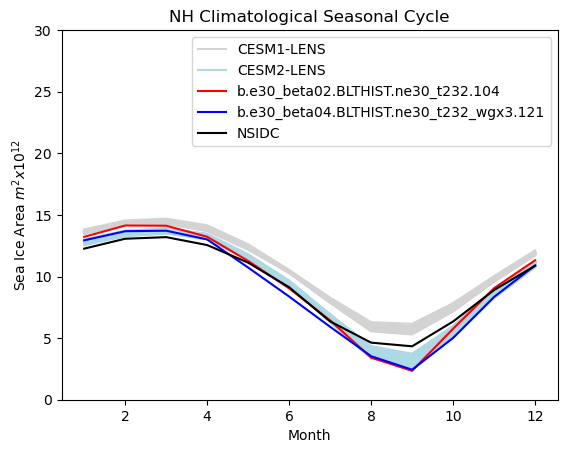

In [13]:
# Northern hemisphere annual cycle plot
tag = "NH"

mask_tmp1_nh = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)
mask_tmp2_nh = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] > 0), 1.0, 0.0)

mask_nh_tmp = np.where(ds1["TLAT"] > 0, tarea, 0.0)
mask_nh = xr.DataArray(data=mask_nh_tmp, dims=["nj", "ni"])

area1 = (aice1_month * mask_nh).sum(["ni", "nj"]) * 1.0e-12
area2 = (aice2_month * mask_nh).sum(["ni", "nj"]) * 1.0e-12

p1 = mlines.Line2D([], [], color="lightgrey", label="CESM1-LENS")
p2 = mlines.Line2D([], [], color="lightblue", label="CESM2-LENS")
p3 = mlines.Line2D([], [], color="red", label=case_name)
p4 = mlines.Line2D([], [], color="blue", label=base_case_name)
p5 = mlines.Line2D([], [], color="black", label="NSIDC")

months = np.linspace(1, 12, 12)

for i in range(0, 38):
    plt.plot(months, cesm1_aicetot_nh_month[i, :] * 1.0e-12, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_aicetot_nh_month[i, :] * 1.0e-12, color="lightblue")
plt.plot(months, area1, color="red")
plt.plot(months, area2, color="blue")
plt.plot(months, nsidc_clim_nh_area, color="black")

plt.title(tag+" Climatological Seasonal Cycle")
plt.ylim((0, 30))
plt.xlabel("Month")
plt.ylabel("Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

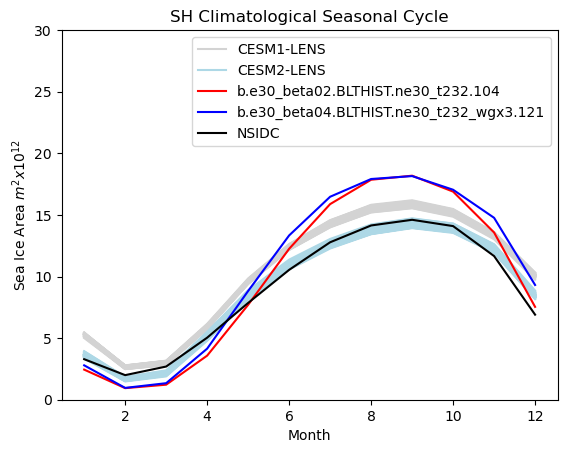

In [14]:
# Southern hemisphere annual cycle plot
tag = "SH"

mask_tmp1_sh = np.where(np.logical_and(aice1_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)
mask_tmp2_sh = np.where(np.logical_and(aice2_month > 0.15, ds1["TLAT"] < 0), 1.0, 0.0)

mask_sh_tmp = np.where(ds1["TLAT"] < 0, tarea, 0.0)
mask_sh = xr.DataArray(data=mask_sh_tmp, dims=["nj", "ni"])

area1 = (aice1_month * mask_sh).sum(["ni", "nj"]) * 1.0e-12
area2 = (aice2_month * mask_sh).sum(["ni", "nj"]) * 1.0e-12

for i in range(0, 38):
    plt.plot(months, cesm1_aicetot_sh_month[i, :] * 1.0e-12, color="lightgrey")
for i in range(0, 49):
    plt.plot(months, cesm2_aicetot_sh_month[i, :] * 1.0e-12, color="lightblue")
plt.plot(months, area1, color="red")
plt.plot(months, area2, color="blue")
plt.plot(months, nsidc_clim_sh_area, color="black")

plt.title(tag+" Climatological Seasonal Cycle")
plt.ylim((0, 30))
plt.xlabel("Month")
plt.ylabel("Sea Ice Area $m^{2} x 10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

# Monthly Analysis for NH Minimum - September

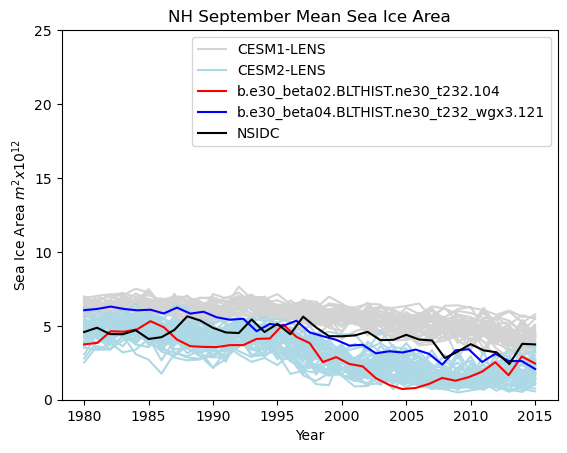

In [17]:
tag = 'NH'

ds1_area = (tarea * ds1.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_sep_nh = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep_nh = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

cesm1_aicetot_nh_sep = ds_cesm1_aicetot_nh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_nh_sep = ds_cesm2_aicetot_nh["aice_monthly"].isel(nmonth=8)

x1 = np.linspace(end_year - len(ds1_sep_nh.time), end_year, len(ds1_sep_nh.time))
x2 = np.linspace(end_year - len(ds2_sep_nh.time), base_end_year, len(ds2_sep_nh.time))
x3 = np.linspace(ds_cesm1_aicetot_nh.year[60], ds_cesm1_aicetot_nh.year[95], 36)
x4 = np.linspace(ds_cesm2_aicetot_nh.year[110], ds_cesm2_aicetot_nh.year[145], 36)
obs_first_year = 0
if first_year > 1:
    obs_first_year = 1979
x5 = np.linspace(1, 36, 36) + obs_first_year

for i in range(0, 38):
    plt.plot(
        x3,
        cesm1_aicetot_nh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        x4,
        cesm2_aicetot_nh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_nh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_nh, x2, x1, color="blue")
plt.plot(x5, sep_area_nh[0:36], color="black")

plt.title("NH September Mean Sea Ice Area")
plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

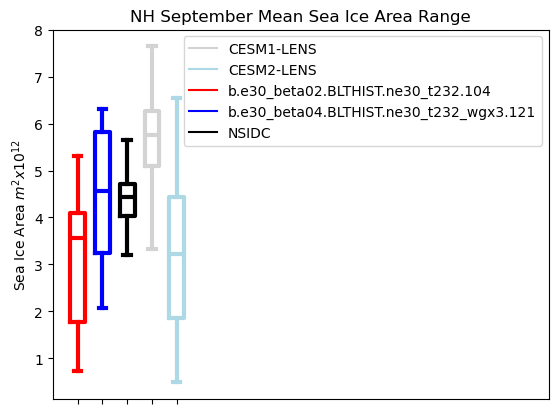

In [19]:
# Box plots

# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = cesm1_aicetot_nh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members","nyr")) * 1.0e-12
cesm2_tmp = cesm2_aicetot_nh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members","nyr")) * 1.0e-12

# plot boxes
boxplots1 = plt.boxplot(ds1_sep_nh, showfliers=False, autorange=False,positions=[0.25])
boxplots2 = plt.boxplot(ds2_sep_nh, showfliers=False, autorange=False,positions=[0.5])
boxplots3 = plt.boxplot(sep_area_nh[0:35], showfliers=False, autorange=False,positions=[0.75])
boxplots4 = plt.boxplot(cesm1_tmp, showfliers=False, autorange=False,positions=[1.0])
boxplots5 = plt.boxplot(cesm2_tmp, showfliers=False, autorange=False,positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8*['red'])
setBoxColor(boxplots2, 8*['blue'])
setBoxColor(boxplots3, 8*['black'])
setBoxColor(boxplots4, 8*['lightgrey'])
setBoxColor(boxplots5, 8*['lightblue'])

# set plot details
plt.title(tag+" September Mean Sea Ice Area Range")
plt.ylabel('Sea Ice Area $m^{2}x10^{12}$')
plt.xlim([0,5])
plt.xticks(visible=False)
plt.legend(handles=[p1, p2, p3, p4, p5])

(array([0.25, 0.5 , 0.75, 1.  , 1.25]),
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.0'),
  Text(1.25, 0, '1.25')])

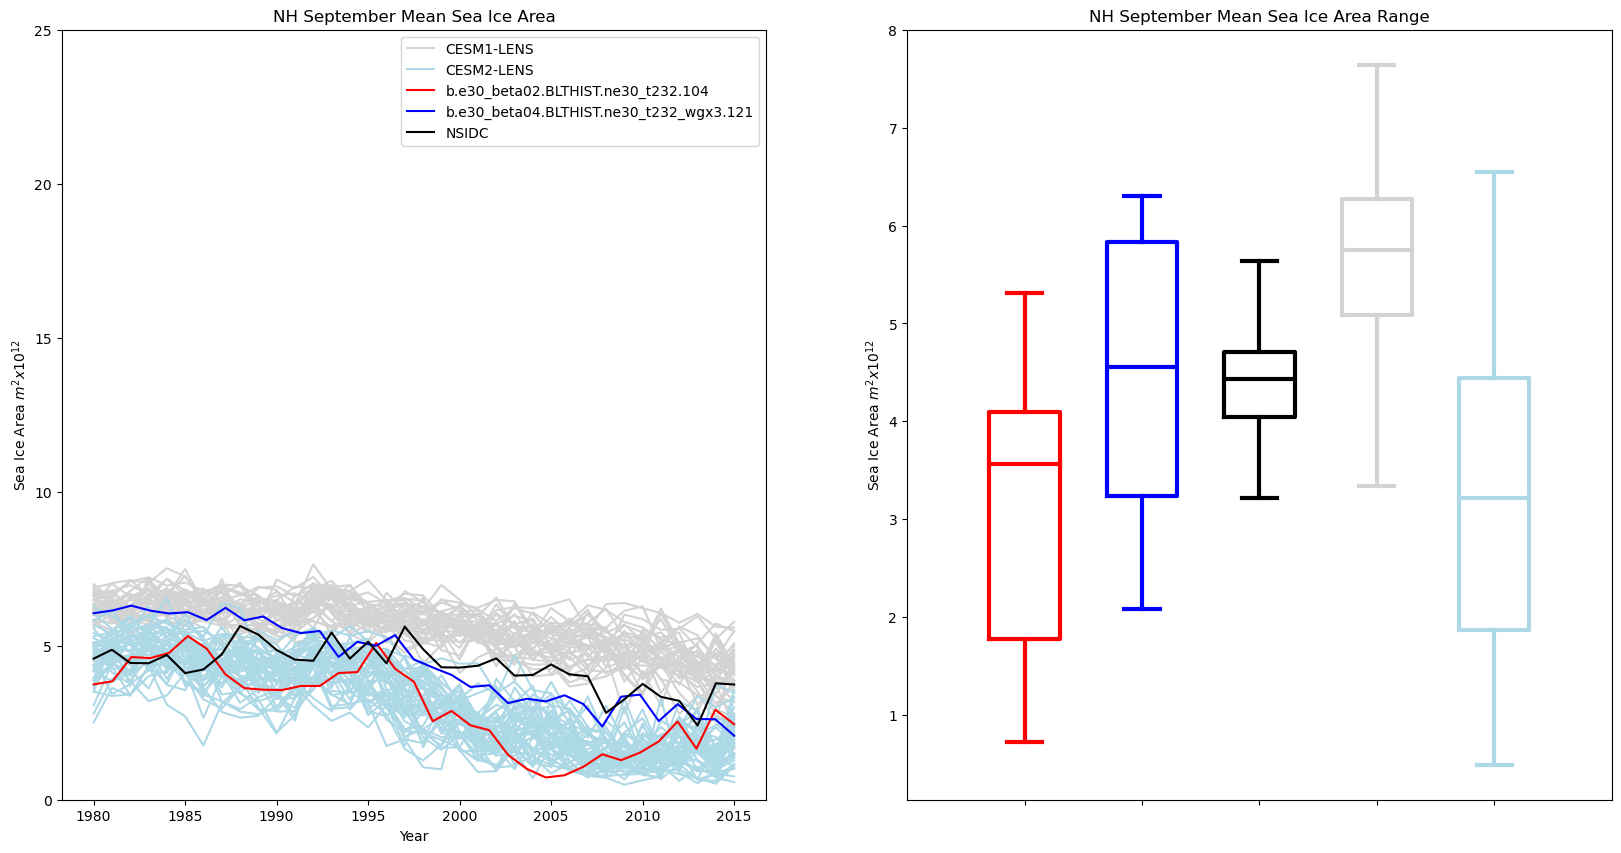

In [20]:
tag = 'NH'

ds1_area = (tarea * ds1.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area = (tarea * ds2.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT > 0
).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_sep_nh = ds1_area.sel(time=(ds1_area.time.dt.month == 9))
ds2_sep_nh = ds2_area.sel(time=(ds2_area.time.dt.month == 9))

cesm1_aicetot_nh_sep = ds_cesm1_aicetot_nh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_nh_sep = ds_cesm2_aicetot_nh["aice_monthly"].isel(nmonth=8)

x1 = np.linspace(end_year - len(ds1_sep_nh.time), end_year, len(ds1_sep_nh.time))
x2 = np.linspace(end_year - len(ds2_sep_nh.time), base_end_year, len(ds2_sep_nh.time))
x3 = np.linspace(ds_cesm1_aicetot_nh.year[60], ds_cesm1_aicetot_nh.year[95], 36)
x4 = np.linspace(ds_cesm2_aicetot_nh.year[110], ds_cesm2_aicetot_nh.year[145], 36)
obs_first_year = 0
if first_year > 1:
    obs_first_year = 1979
x5 = np.linspace(1, 36, 36) + obs_first_year


# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left) 
fig = plt.figure(figsize=(20,10))

### First panel, timeseries
ax = fig.add_subplot(1,2,1) 
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_aicetot_nh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_aicetot_nh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_nh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_nh, x2, x1, color="blue")
ax.plot(x5, sep_area_nh[0:36], color="black")

plt.title(tag+" September Mean Sea Ice Area")
plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

### Second panel, boxplot
ax = fig.add_subplot(1,2,2) 
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = cesm1_aicetot_nh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members","nyr")) * 1.0e-12
cesm2_tmp = cesm2_aicetot_nh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members","nyr")) * 1.0e-12

# plot boxes
boxplots1 = ax.boxplot(ds1_sep_nh, showfliers=False, autorange=False,positions=[0.25])
boxplots2 = ax.boxplot(ds2_sep_nh, showfliers=False, autorange=False,positions=[0.5])
boxplots3 = ax.boxplot(sep_area_nh[0:35], showfliers=False, autorange=False,positions=[0.75])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False,positions=[1.0])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False,positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8*['red'])
setBoxColor(boxplots2, 8*['blue'])
setBoxColor(boxplots3, 8*['black'])
setBoxColor(boxplots4, 8*['lightgrey'])
setBoxColor(boxplots5, 8*['lightblue'])

# set plot details
plt.title(tag+" September Mean Sea Ice Area Range")
plt.ylabel('Sea Ice Area $m^{2}x10^{12}$')
plt.xlim([0,1.5])
plt.xticks(visible=False)

# Monthly Analysis for SH Maximum - September

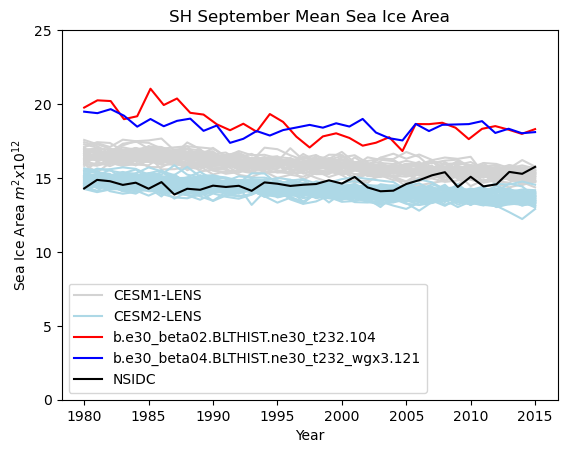

In [21]:
tag = 'SH'

ds1_area_sh = (tarea * ds1.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_sh = (tarea * ds2.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_sep_sh = ds1_area_sh.sel(time=(ds1_area_sh.time.dt.month == 9))
ds2_sep_sh = ds2_area_sh.sel(time=(ds2_area_sh.time.dt.month == 9))

cesm1_aicetot_sh_sep = ds_cesm1_aicetot_sh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_sh_sep = ds_cesm2_aicetot_sh["aice_monthly"].isel(nmonth=8)

x1 = np.linspace(end_year - len(ds1_sep_sh.time), end_year, len(ds1_sep_sh.time))
x2 = np.linspace(end_year - len(ds2_sep_sh.time), base_end_year, len(ds2_sep_sh.time))
x3 = np.linspace(ds_cesm1_aicetot_nh.year[60], ds_cesm1_aicetot_nh.year[95], 36)
x4 = np.linspace(ds_cesm2_aicetot_nh.year[110], ds_cesm2_aicetot_nh.year[145], 36)


obs_first_year = 0
if first_year > 1:
    obs_first_year = 1979
x5 = np.linspace(1, 36, 36) + obs_first_year

for i in range(0, 38):
    plt.plot(
        x3,
        cesm1_aicetot_sh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    plt.plot(
        x4,
        cesm2_aicetot_sh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep_sh, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep_sh, x2, x1, color="blue")
plt.plot(x5, sep_area_sh[0:36], color="black")

plt.title(tag+" September Mean Sea Ice Area")
plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

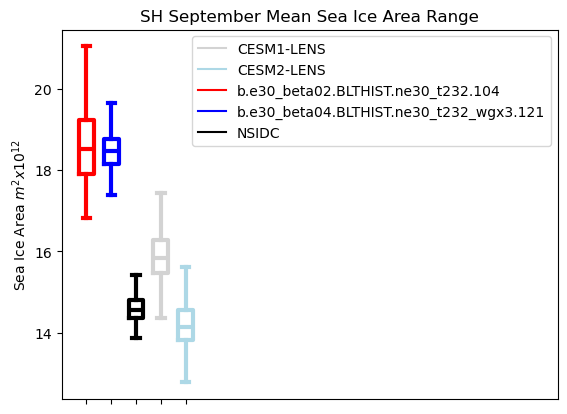

In [22]:
# Box plots

# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = cesm1_aicetot_sh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members","nyr")) * 1.0e-12
cesm2_tmp = cesm2_aicetot_sh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members","nyr")) * 1.0e-12

# plot boxes
boxplots1 = plt.boxplot(ds1_sep_sh, showfliers=False, autorange=False,positions=[0.25])
boxplots2 = plt.boxplot(ds2_sep_sh, showfliers=False, autorange=False,positions=[0.5])
boxplots3 = plt.boxplot(sep_area_sh[0:35], showfliers=False, autorange=False,positions=[0.75])
boxplots4 = plt.boxplot(cesm1_tmp, showfliers=False, autorange=False,positions=[1.0])
boxplots5 = plt.boxplot(cesm2_tmp, showfliers=False, autorange=False,positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8*['red'])
setBoxColor(boxplots2, 8*['blue'])
setBoxColor(boxplots3, 8*['black'])
setBoxColor(boxplots4, 8*['lightgrey'])
setBoxColor(boxplots5, 8*['lightblue'])

# set plot details
plt.title(tag+" September Mean Sea Ice Area Range")
plt.ylabel('Sea Ice Area $m^{2}x10^{12}$')
plt.xlim([0,5])
plt.xticks(visible=False)
plt.legend(handles=[p1, p2, p3, p4, p5])

In [ ]:
tag = 'SH'

ds1_area_sh = (tarea * ds1.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_area_sh = (tarea * ds2.aice).isel(time=slice(-climo_nyears * 12, None)).where(
    TLAT < 0
).sum(dim=["nj", "ni"]) * 1.0e-12

ds1_sep_sh = ds1_area_sh.sel(time=(ds1_area_sh.time.dt.month == 9))
ds2_sep_sh = ds2_area_sh.sel(time=(ds2_area_sh.time.dt.month == 9))

cesm1_aicetot_sh_sep = ds_cesm1_aicetot_sh["aice_monthly"].isel(nmonth=8)
cesm2_aicetot_sh_sep = ds_cesm2_aicetot_sh["aice_monthly"].isel(nmonth=8)

x1 = np.linspace(end_year - len(ds1_sep.time), end_year, len(ds1_sep.time))
x2 = np.linspace(end_year - len(ds2_sep.time), base_end_year, len(ds2_sep.time))
x3 = np.linspace(ds_cesm1_aicetot_sh.year[60], ds_cesm1_aicetot_sh.year[95], 36)
x4 = np.linspace(ds_cesm2_aicetot_sh.year[110], ds_cesm2_aicetot_sh.year[145], 36)

obs_first_year = 0
if first_year > 1:
    obs_first_year = 1979
x5 = np.linspace(1, 36, 36) + obs_first_year


# Make Plot - two subplots - note it's nrow x ncol x index (starting upper left) 
fig = plt.figure(figsize=(20,10))

### First panel, timeseries
ax = fig.add_subplot(1,2,1) 
for i in range(0, 38):
    ax.plot(
        x3,
        cesm1_aicetot_sh_sep.isel(n_members=i, nyr=slice(60, 96)) * 1.0e-12,
        color="lightgrey",
    )
for i in range(0, 49):
    ax.plot(
        x4,
        cesm2_aicetot_sh_sep.isel(n_members=i, nyr=slice(110, 146)) * 1.0e-12,
        color="lightblue",
    )
plt_plot_len_x_might_be_one(ds1_sep, x1, x2, color="red")
plt_plot_len_x_might_be_one(ds2_sep, x2, x1, color="blue")
ax.plot(x5, sep_area_sh[0:36], color="black")

plt.title(tag+" September Mean Sea Ice Area")
plt.ylim((0, 25))
plt.xlabel("Year")
plt.ylabel("Sea Ice Area $m^{2}x10^{12}$")
plt.legend(handles=[p1, p2, p3, p4, p5])

### Second panel, boxplot
ax = fig.add_subplot(1,2,2) 
# get just last years of large ensembles and one dimensionalize them
cesm1_tmp = cesm1_aicetot_sh_sep.isel(nyr=slice(60, 96)).stack(new=("n_members","nyr")) * 1.0e-12
cesm2_tmp = cesm2_aicetot_sh_sep.isel(nyr=slice(110, 146)).stack(new=("n_members","nyr")) * 1.0e-12

# plot boxes
boxplots1 = ax.boxplot(ds1_sep_sh, showfliers=False, autorange=False,positions=[0.25])
boxplots2 = ax.boxplot(ds2_sep_sh, showfliers=False, autorange=False,positions=[0.5])
boxplots3 = ax.boxplot(sep_area_sh[0:35], showfliers=False, autorange=False,positions=[0.75])
boxplots4 = ax.boxplot(cesm1_tmp, showfliers=False, autorange=False,positions=[1.0])
boxplots5 = ax.boxplot(cesm2_tmp, showfliers=False, autorange=False,positions=[1.25])

# set colors for each box
setBoxColor(boxplots1, 8*['red'])
setBoxColor(boxplots2, 8*['blue'])
setBoxColor(boxplots3, 8*['black'])
setBoxColor(boxplots4, 8*['lightgrey'])
setBoxColor(boxplots5, 8*['lightblue'])

# set plot details
plt.title(tag+" September Mean Sea Ice Area Range")
plt.ylabel('Sea Ice Area $m^{2}x10^{12}$')
plt.xlim([0,1.5])
plt.xticks(visible=False)

# Labrador Sea Timeseries

In [ ]:
latm = cice_masks["Lab_lat"]
lonm = cice_masks["Lab_lon"]

lon = np.where(TLON < 0, TLON + 360.0, TLON)
mask1 = np.where(np.logical_and(TLAT > latm[0], TLAT < latm[1]), 1.0, 0.0)
mask2 = np.where(np.logical_or(lon > lonm[0], lon < lonm[1]), 1.0, 0.0)
mask = mask1 * mask2

ds1_lab = (mask * tarea * ds1.aice).sum(dim=["nj", "ni"]) * 1.0e-12
ds2_lab = (mask * tarea * ds2.aice).sum(dim=["nj", "ni"]) * 1.0e-12

# just want maximum extent (so March)
ds1_lab_mar = ds1_lab.sel(time=ds1_lab.time.dt.month == 3)
ds2_lab_mar = ds2_lab.sel(time=ds2_lab.time.dt.month == 3)

ds1_lab_mar.plot(color="red")
ds2_lab_mar.plot(color="blue")

plt.title("Labrador Sea Montly Mean Sea Ice Area")
plt.ylim((0, 10))
plt.xlabel("Month")
plt.ylabel("Labrador Sea Ice Area $m x 10^{12}$")
plt.legend([case_name, base_case_name])